## Authors's Gender Biopic Text Classification 

> Wikipedia Data



This notebook demonstrates text classification starting from plain text files stored on disk. I'll train a binary classifier to perform Gender classfication on Wikipedia's authors biopic.


In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [ ]:
print(tf.__version__)

2.8.2



Gender Classfication

This notebook trains a model to classify the author's biopic either male or female.


### Import and export data

Import text dataset extract the dataset, then explore the directory structure.

In [ ]:
url = "sample_data/gender bio.zip"
import zipfile
path_to_zip_file = url
directory_to_extract_to = "sample_data"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
dataset = "sample_data"

dataset_dir = "sample_data/gender bio"

In [ ]:
print(dataset_dir)
os.listdir(dataset_dir)

sample_data/gender bio


['test', 'train']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['female bio', 'male bio']

The `gender bio/train/female` and `gender bio/train/male` directories contain many text files, each of which is a single author's biopic. 

In [ ]:
sample_file = os.path.join(train_dir, 'male bio/Aaron Allston.txt')
with open(sample_file) as f:
  print(f.read())

Aaron Dale Allston (December 8, 1960 – February 27, 2014) was an American game designer and author of many science fiction books, notably Star Wars novels.[1] His works as a game designer include game supplements for role-playing games, several of which served to establish the basis for products and subsequent development of TSR's Dungeons & Dragons game setting Mystara. His later works as a novelist include those of the X-Wing series: Wraith Squadron, Iron Fist, Solo Command, Starfighters of Adumar, and Mercy Kill. He wrote two entries in the New Jedi Order series: Enemy Lines I: Rebel Dream and Enemy Lines II: Rebel Stand. Allston wrote three of the nine Legacy of the Force novels: Betrayal, Exile, and Fury, and three of the nine Fate of the Jedi novels: Outcast, Backlash, and Conviction.
Allston was born December 8, 1960, in Corsicana, Texas, to Tom Dale Allston and Rose Binford Boehm.[2][3] Allston moved all over Texas in his youth and graduated from high school in Denton.[4] An av

### Load the dataset

Next, I will load the data off disk and prepare it into a format suitable for training. To do so, I  will use the helpful text_dataset_from_directory utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

*Next*, I will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. tf.data is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide  dataset into three splits:train, validation, and test.

I created a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'sample_data/gender bio/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.


As you can see above, there are 2000 examples in the training folder, of which you will use 80% (or 1600) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. I iterate over the dataset and print out a few examples as follows.

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("biopic", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

biopic b'Thomas H. Bender is an American historian, specializing in urban history and intellectual history. He joined New York University in 1974 and served there as University Professor of the Humanities from 1982 until his retirement.[1][2] He contributes regularly to the press, with articles published in the New York Times, The Nation, Los Angeles Times, Chronicle of Higher Education, and Newsday, among others. He retired in May 2015.\r\nHe graduated from Santa Clara University with a B.A. (1966) and the University of California, Davis with an M.A. (1967) and a Ph.D. (1971). He taught Urban Studies and History for three years at the University of Wisconsin\xe2\x80\x93Green Bay from 1971 before moving to New York University. During his tenure there, he was Chair at the Department of History from 1986 to 1989, and Dean for the Humanities from 1995 to 1998.\r\nHe moderated an online discussion at History Matters.[3]\r\n'
Label 1
biopic b'\r\nNatalie Clifford Barney (October 31, 1876 \x

Notice the  author's biopic contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to female and male aurthor, you can check the `class_names` property on the dataset.


In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to female bio
Label 1 corresponds to male bio



 When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [ ]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'sample_data/gender bio/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 2000 files belonging to 2 classes.
Using 400 files for validation.


In [ ]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'sample_data/gender bio/test', 
    batch_size=batch_size)

Found 400 files belonging to 2 classes.


### Prepare the dataset for training

> Indented block



Next, I will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the authors biopic contain various HTML tags like `<br />`. These tags are not removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). I wrote a custom standardization function to remove the HTML.

To prevent training-testing skew (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

 `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

A function to see the result of using this layer to preprocess some data.

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_author_biopic, first_label = text_batch[0], label_batch[0]
print("Author's biopic", first_author_biopic)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized Author's biopic", vectorize_text(first_author_biopic, first_label))

Review tf.Tensor(b"Deborah Coates is an American author.  She grew up in western New York, and currently lives in Ames, Iowa.[1]  Her stories have been included in Strange Horizons, SCIFICTION, Best American Fantasy 2008, Year's Best Fantasy 6, and Best Paranormal Romance.[2]\r\n\r\nThis American novelist article is a stub. You can help Wikipedia by expanding it.This article about an American short story writer is a stub. You can help Wikipedia by expanding it.", shape=(), dtype=string)
Label female bio
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[3331,    1,   16,   21,   26,   71,   15,  304,   89,    4,  561,
          23,   36,    3,  345,  220,    4, 2598,    1,   12,   74,   56,
          48,  279,    4, 1740, 5608,    1,   61,   26,  239,  180,   59,
          61,  239,  814,    3,   61, 2799,    1,   45,   26,  179,  199,
          16,    6,  369,  101,  150,  233,  364,   20,  355, 2631,  199,
          40,   21,   26,   81,   68,   62,   16,    6

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  poets
 313 --->  nominated
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training  model. If  dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model



In [ ]:
embedding_dim = 16

In [ ]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`. 
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))



```
# This is formatted as code
```

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
50/50 [==============================] - 4s 16ms/step - loss: 0.6890 - binary_accuracy: 0.6469 - val_loss: 0.6852 - val_binary_accuracy: 0.7200
Epoch 2/10
50/50 [==============================] - 0s 5ms/step - loss: 0.6778 - binary_accuracy: 0.7981 - val_loss: 0.6731 - val_binary_accuracy: 0.8225
Epoch 3/10
50/50 [==============================] - 0s 5ms/step - loss: 0.6616 - binary_accuracy: 0.8500 - val_loss: 0.6560 - val_binary_accuracy: 0.8575
Epoch 4/10
50/50 [==============================] - 0s 5ms/step - loss: 0.6398 - binary_accuracy: 0.8750 - val_loss: 0.6340 - val_binary_accuracy: 0.8650
Epoch 5/10
50/50 [==============================] - 0s 5ms/step - loss: 0.6139 - binary_accuracy: 0.8981 - val_loss: 0.6077 - val_binary_accuracy: 0.8800
Epoch 6/10
50/50 [==============================] - 0s 5ms/step - loss: 0.5838 - binary_accuracy: 0.9169 - val_loss: 0.5782 - val_binary_accuracy: 0.8850
Epoch 7/10
50/50 [==============================] - 0s 5ms/step - loss: 0.5



```
`# This is formatted as code`
```

### Evaluate the model

Loss (a number which represents our error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

13/13 [==============================] - 0s 7ms/step - loss: 0.4680 - binary_accuracy: 0.9250
Loss:  0.4680285155773163
Accuracy:  0.925000011920929


This fairly naive approach achieves an accuracy of about 92%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. I Plot the training and validation loss for comparison, as well as the training and validation accuracy:

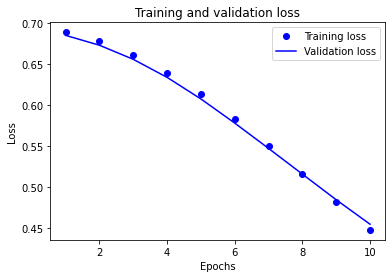

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

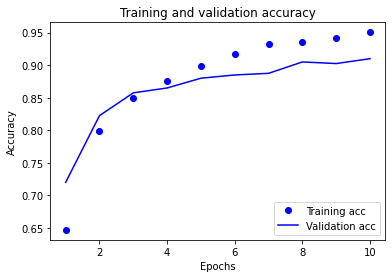

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.




```
# This is formatted as code
```

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

13/13 [==============================] - 0s 8ms/step - loss: 0.4680 - accuracy: 0.9250
0.925000011920929


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [ ]:
examples = [
  "Martin was born on September 8 in the Bronx borough of New York City, the only child Joseph G. Martin and Josephine DiLorenzo, both journalists who met and married while working at the New York Daily News. Joseph G. Martin had a career that spanned more than 45 years. As a reporter for the New York Daily News, he won nearly every possible honor for reporting: a Selurians Award (1950); two George Polk Awards (1952 and 1973) and a Newspaper Guild Page One Award (1956).[2] In 1959, Martin won a Pulitzer Prize for international reporting for a 10-part series co-written with Philip Santori on Cuban dictator Fulgencio Batista.[3] The piece predicted the fall of Batista months before it happened and was called “prophetic journalism” by the Pulitzer committee. Martin also served as New York Deputy Police Commissioner for public relations from 1965 to 1968.[2] Josephine DiLorenzo was raised in the Bronx. A highly gifted student, she graduated high school at 15 and entered Hunter College at 16 years of age. She got a job as one of the first female copyboys at the New York Daily News, working her way up to a reporter. Besides Daily News stories, DiLorenzo wrote celebrity interviews, including in-depth talks with Marilyn Monroe and Elizabeth Taylor. After becoming a stay-at-home Mom, DiLorenzo continued writing a weekly column for the Daily News titled “Trips and Treats.”[4] Following her graduation from Ursuline Highschool in the Bronx, Martin attended Boston College, graduating summa cum laude with a degree in Broadcast Communications and Theater. While at Boston College, she founded America’s oldest collegiate improv comedy troupe called My Mother’s Fleabag which boasts a slew of celebrity alumni such as Amy Poehler",
  "Miller is of African American and Philippine American ancestry and identifies as BIPOC. Her paternal family is from Washington, D.C. and her maternal family is Filipino Creole from the U.S. Virgin Islands. Miller's grandmother was an indigenous Danish west Indian and Ghanaian. Her great-great grandmother is of Ghanaian descent from St. Johns. Her Philippine grandfather was part of the U.S. Filipino navy as a steward's cook during WWI in 1917. Her grandparents met at the USO and married. Having three Filipino lineages of their own, Miller's mother being one of them. Her mother, a Filipino-Creole, came to the United States to attend Howard University. Her maternal Afro-Caribbean Saint-Tomian cousin Larry was installed as a chief of their tribe. Their tribe are artisans, specifically shipbuilders, wood carvers and make decorative coffins. Her paternal grandfather was white and American Indian with Patriotic daughters of American Revolution DNA.[1] Miller's parents met at Howard University in Washington, D.C. where they settled and began the family of their own. She was a Girl Scout and when she won her first award, she was published on the section covers of The Washington Post and Washington Star. As a child, Miller spent most of her days at museums looking at an era of contemporary art and the cadre of Washington color field schools. In 1969, her teacher told her that she will never make it as an artist, but her specific experiences and heritage became formative to her art practice.[1] Miller graduated from Calvin Coolidge High School. In 1985, she received a Masters of Science in Visual Communications at the Pratt Institute.[2] As a thesis project, she was asked to make a contribution to the field of graphic design and instead of a visual design project she wrote Transcending the Problems of the Black Designer to Success in the Marketplace as her thesis.[3][4] Millers 1985 thesis studies design, sociology and history to give a portrait of African American job prospects.[5] She later attended the Rhode Island School of Design but when Miller's father died, she transferred to Maryland Institute College of Art where she lived closer to her mother.[3] Miller was awarded a Doctor of Humane Letters from the Vermont College of Fine Arts in February 2021.[6] In May of 2022, Miller was awarded a Doctor of Fine Arts from Maryland Institute College of Art.[7][8] In June of 2022, Miller was awarded a Doctor of Fine Arts from the Rhode Island School of Design.",
  "Moscovici was born in Bucharest, Romania. At the age of 12, she immigrated with her family to the United States where she has gone on to obtain a B.A. from Princeton University and a Ph.D. in Comparative Literature from Brown University. Moscovici taught philosophy, literature and arts and ideas at Boston University and at the University of Michigan. Born in Bucharest, Romania, she writes from her experience of life in a totalitarian regime, which marked her deeply.",
  "Born in Los Angeles, Nishi was the daughter of Hatsu and Tahei Matsunaga who had emigrated to the United States from Kumamoto, Japan.[3] Her father was a hotel owner in the Little Tokyo district of Los Angeles. She attended Theodore Roosevelt High School before enrolling as a music student at the University of Southern California. A trained classical pianist, she often played with her sister Helen who was a violinist. Despite writing a telegram to President Roosevelt complaining about internment as undemocratic she had to interrupt her studies and her music career in spring 1942 when, as Japanese Americans, she and her family were incarcerated at the Santa Anita Assembly Center following the Japanese attack on Pearl Harbor.[1] Five months later, in the fall of 1942, she and her sister were among the first students to leave the internment camp thanks to the efforts of the National Japanese American Student Relocation Council. Nishi then studied sociology at Washington University in St. Louis where she earned a master's degree in 1944. She completed her education at the sociology department of the University of Chicago where she ultimately received a doctorate in 1963.",
  "Patricia T OConner (born February 19, 1949) is the author of five books about the English language.[1] A former editor at The New York Times Book Review, she appears monthly on WNYC as the word maven for The Leonard Lopate Show.[2] She has written extensively for The New York Times, including On Language columns, book reviews, and articles for the op-ed page and the Week in Review section. She and Stewart Kellerman, her husband and co-author of several books and articles, answer questions about the English language on The Grammarphobia Blog.[3] She graduated from Grinnell College in 1971 with a BA in philosophy, and received an honorary degree from Grinnell in 2006.",
  "Chaon was born June 11, 1964 in either Sidney, Nebraska[1][2] or Omaha, Nebraska,[3] and was the adopted son of Earl D. Chaon and Teresa N. (Tallmage) Chaon. His father was a construction worker and his mother a stay-at-home mom, neither of whom graduated from high school. He was the oldest of three siblings. He grew up in a village of 20 people outside of Sidney, Nebraska. Chaon has said about his childhood, I was a weird kid: bookish, imaginative, and not athletic. He was a voracious young reader: At 10, I wanted to read The New Yorker. Foreshadowing some themes of his later writing, he noted, I grew up on a steady diet of SF and horror and ghost stories, and that’s still a love of mine, and that as a teenager he was fascinated by the serial killer novels that were popular in the 1980s. Furthermore, he said, Ive written stories since I was a little kid. He credits his parents for their support: I had parents who, however puzzled they were by my weirdness, were tolerant of it and loving.",
  "Charney was born in New Haven, Connecticut in 1979. His parent a psychiatrist and a professor of French Literature at Yale University, were, in his wordof the class of Americans who idealize Europe and as a youth he spent most of his summers in France.[1] He attended Choate Rosemary Hall, and received his undergraduate education at Colby College in Maine, where he majored in Art History and English Literature During this period he participated in exchange programs in both Paris and London Also while at Colby he founded the Colby Film Society and wrote several plays, one of which won the Horizons New Young Playwrights Competition in Atlanta, Georgia,[3] in 2002 the year of his graduation. After graduating he moved to London, where he studied at the Courtauld Institute and received a Masters for his work on seventeenth century sculpture in Rome. He subsequently attended Cambridge University S Johns College where he received a second Masters in Historywriting on Bronzino London Allegory and began a PhD, but chose not to complete his thesis. In the fall of 2012, he received a PhD in Art History from the University of Ljubljana, with a thesis on the work of the Slovenian architect Jože Plečnik 1872–1957",
  "Kevin Canty (born January 17, 1953) is an American novelist and short story writer. He is a faculty member in the English department at the University of Montana at Missoula, where he currently resides.[1] Canty received his master's degree in English from the University of Florida in 1990.[2] He received his M.F.A. in creative writing from the University of Arizona in 1993.",
  "Christopher Robert Cargill (born September 8, 1975) is an American screenwriter, novelist, podcast host, and former film critic known under the pseudonyms Massawyrm (on Ain't It Cool News) and Carlyle (on Spill.com). Cargill currently resides in Austin, Texas with his wife.[1] He is best known for writing the films Sinister (2012), Sinister 2 (2015), Doctor Strange (2016), and The Black Phone (2021). He is a frequent writing collaborator of Scott Derrickson. Cargill was raised in a military family, growing up on army bases around the United States. He held several jobs prior to writing, including video store clerk and travel agent.[citation needed]",
  "he is Card (born August 24, 1951) is an American writer. He is currently the only person to win both a Hugo Award and a Nebula Award in consecutive years, winning both awards for both his novel Ender's Game (1985) and its sequel Speaker for the Dead (1986) back-to-back. A feature film adaptation of Ender's Game, which Card co-produced, was released in 2013. Card also wrote the Locus Fantasy Award-winning series The Tales of Alvin Maker (1987–2003)."
]

export_model.predict(examples)

array([[0.4781294 ],
       [0.32479757],
       [0.4594456 ],
       [0.40370232],
       [0.4458747 ],
       [0.47114527],
       [0.7147199 ],
       [0.55211544],
       [0.5533681 ],
       [0.49372795]], dtype=float32)